<a href="https://colab.research.google.com/github/vipulprabhu2000/pneumonia_classifier/blob/master/PATE_Pneumonia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PSL Internship**

GEC_Batch_32

In [ ]:
## install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft -q

     |████████████████████████████████| 440kB 4.8MB/s 
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 9.0MB 48.6MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 450kB 49.9MB/s 
     |████████████████████████████████| 204kB 52.6MB/s 
     |████████████████████████████████| 1.8MB 45.7MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 2.0MB 48.0MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 133kB 59.8MB/s 
     |████████████████████████████████| 4.0MB 37.8MB/s 
     |████████████████████████████████| 491kB 48.0MB/s 
     |████████████████████████████████| 2.2MB 44.9MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
    

In [ ]:
# import our libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import time, os, random

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

from torchsummary import summary 

from torchvision.utils import make_grid
from torch.utils.data import random_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## authorize access to google drive
from google.colab import drive
drive.mount('/content/drive')

# navigate to project directory
%cd '/content/drive/My Drive/Colab Notebooks/OpenMined/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/OpenMined


In [ ]:
# Custom dataset
#downloaded from kaggle, uploaded from drive.
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, txt_NORMAL, txt_PNEUMONIA, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - NORMAL
                - images
                - ......
            - PNEUMONIA
                - images
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_NORMAL,txt_PNEUMONIA]
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
        return image, label

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [ ]:
batchsize=16
path = './data/images'

# Transforms used for datasets
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
])

# divided among teachers
trainset = ChestXrayDataset(root_dir=f'{path}',
                              txt_NORMAL='./data/labels/NORMAL/trainNORMAL.txt',
                              txt_PNEUMONIA='./data/labels/PNEUMONIA/trainPNEUMONIA.txt',
                              transform= data_transforms)

# used as student valid set    
validset = ChestXrayDataset(root_dir=f'{path}',
                              txt_NORMAL='./data/labels/NORMAL/valNORMAL.txt',
                              txt_PNEUMONIA='./data/labels/PNEUMONIA/valPNEUMONIA.txt',
                              transform= data_transforms)

# used as student train set    
testset = ChestXrayDataset(root_dir=f'{path}',
                              txt_NORMAL='./data/labels/NORMAL/testNORMAL.txt',
                              txt_PNEUMONIA='./data/labels/PNEUMONIA/testPNEUMONIA.txt',
                              transform= data_transforms)

print("Number of Classes: ",len(trainset.classes))
len(trainset), len(testset), len(validset)

Number of Classes:  2


(4582, 924, 350)

torch.Size([16, 3, 224, 224]) tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0])


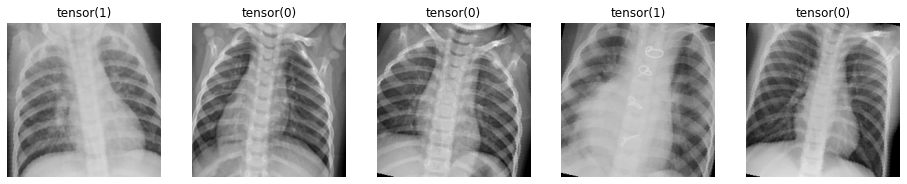

In [ ]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the train set

images, labels = next(iter(data_loader))
print(images.shape, labels)
images

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [ ]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [ ]:
#  # STUDENT
# split into train and validation set
valid_size = int(len(testset) * 0.3)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(21, 9)

In [ ]:
class SimpleCNN(torch.nn.Module):
      def __init__(self):
        super().__init__()
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
        layer1.add_module('drop1',torch.nn.Dropout(0.25))
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        layer1.add_module('conv1', torch.nn.Conv2d(3,64, 3, 1, padding=1))
        layer1.add_module('drop1',torch.nn.Dropout(0.25))
        layer1.add_module('relu2', torch.nn.ReLU(True))
        layer1.add_module('pool2', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1

        layer2 = torch.nn.Sequential()
        layer2.add_module('fc1', torch.nn.Linear(200704, 2))
        self.layer2 = layer2
        
      def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer2(fc_input)
        return fc_out

In [ ]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model

In [ ]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 5

In [ ]:
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*50)

 Training Teacher 1
Epoch: 1 
	Train Loss: 5.671895 	Train Acc: 75.443383 
	Valid Loss: 1.306926 	Valid Acc: 80.874317
Epoch: 2 
	Train Loss: 0.789388 	Train Acc: 86.766712 
	Valid Loss: 0.382339 	Valid Acc: 89.071038
Epoch: 3 
	Train Loss: 0.451482 	Train Acc: 88.676671 
	Valid Loss: 0.377517 	Valid Acc: 89.071038
Epoch: 4 
	Train Loss: 0.314177 	Train Acc: 89.768076 
	Valid Loss: 0.226766 	Valid Acc: 92.349727
Epoch: 5 
	Train Loss: 0.324960 	Train Acc: 90.995907 
	Valid Loss: 0.278723 	Valid Acc: 90.710383
 Training Teacher 2
Epoch: 1 
	Train Loss: 0.333169 	Train Acc: 90.040928 
	Valid Loss: 0.290783 	Valid Acc: 88.524590
Epoch: 2 
	Train Loss: 0.267802 	Train Acc: 92.769441 
	Valid Loss: 0.247014 	Valid Acc: 90.163934
Epoch: 3 
	Train Loss: 0.347447 	Train Acc: 90.313779 
	Valid Loss: 0.192838 	Valid Acc: 95.628415
Epoch: 4 
	Train Loss: 0.306401 	Train Acc: 91.268759 
	Valid Loss: 0.123237 	Valid Acc: 92.896175
Epoch: 5 
	Train Loss: 0.422019 	Train Acc: 90.450205 
	Valid Loss: 0

In [ ]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(647, 5)
[1 1 1 1 1]


In [ ]:
# Get private labels with the most votes count and add noise them
epsilon=0.1

def add_noise(predicted_labels, epsilon=epsilon):
  noisy_labels = []
  for preds in predicted_labels:

    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)

    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)

labels_with_noise = add_noise(predicted_labels, epsilon=epsilon)  
print(labels_with_noise)
print(labels_with_noise.shape)

[1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0
 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0
 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0
 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1
 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1
 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1
 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1
 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0
 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1
 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0
 1 1 0 1 0 0 1 1 0 0 0 0 

In [ ]:
#write to csv file
import csv
def write_csv(data):
  with open('labels.csv', 'a') as outfile:
      writer = csv.writer(outfile)
      writer.writerow(data)

write_csv(labels_with_noise)

In [ ]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=epsilon, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 37.392925464969856
Data independent epsilon: 37.39292546497023


In [ ]:
# We have to create a new training dataloader for the student with the newly created
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)

  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(21, 9)

In [ ]:
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./student.pth.tar', is_not_teacher=True)

Epoch: 1 
	Train Loss: 1.679032 	Train Acc: 54.404946 
	Valid Loss: 1.057793 	Valid Acc: 56.678700
	Validation loss decreased (inf --> 1.057793).  Saving model ...
Epoch: 2 
	Train Loss: 0.966129 	Train Acc: 62.132921 
	Valid Loss: 0.777702 	Valid Acc: 58.844765
	Validation loss decreased (1.057793 --> 0.777702).  Saving model ...
Epoch: 3 
	Train Loss: 0.676011 	Train Acc: 66.151468 
	Valid Loss: 0.704973 	Valid Acc: 60.288809
	Validation loss decreased (0.777702 --> 0.704973).  Saving model ...
Epoch: 4 
	Train Loss: 0.371268 	Train Acc: 81.607419 
	Valid Loss: 0.717804 	Valid Acc: 61.732852
Epoch: 5 
	Train Loss: 0.281098 	Train Acc: 89.026275 
	Valid Loss: 0.772089 	Valid Acc: 58.483755


In [ ]:
# Normal DL Training
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./normal.pth.tar', is_not_teacher=True)

Epoch: 1 
	Train Loss: 0.484794 	Train Acc: 78.052550 
	Valid Loss: 0.608976 	Valid Acc: 80.505415
	Validation loss decreased (inf --> 0.608976).  Saving model ...
Epoch: 2 
	Train Loss: 0.398522 	Train Acc: 85.316847 
	Valid Loss: 0.266165 	Valid Acc: 89.530686
	Validation loss decreased (0.608976 --> 0.266165).  Saving model ...
Epoch: 3 
	Train Loss: 0.380817 	Train Acc: 87.017002 
	Valid Loss: 0.287362 	Valid Acc: 87.364621
Epoch: 4 
	Train Loss: 0.277632 	Train Acc: 89.953632 
	Valid Loss: 0.317424 	Valid Acc: 88.086643
Epoch: 5 
	Train Loss: 0.255281 	Train Acc: 91.344668 
	Valid Loss: 0.312643 	Valid Acc: 88.808664


In [ ]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

350


Student Model
	Test Loss: 0.158050
	Test Accuracy: 94% (331/350)


<Figure size 432x288 with 0 Axes>

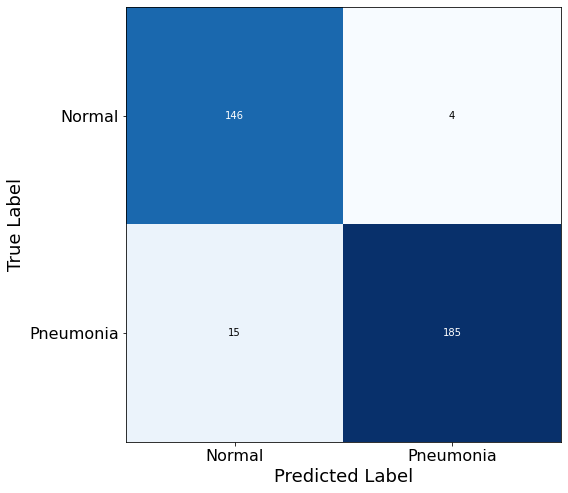

Accuracy of the model is 0.95
Recall of the model is 0.93
Precision of the model is 0.98
F1 Score of the model is 0.95

Normal Model
	Test Loss: 0.175293
	Test Accuracy: 94% (331/350)


<Figure size 432x288 with 0 Axes>

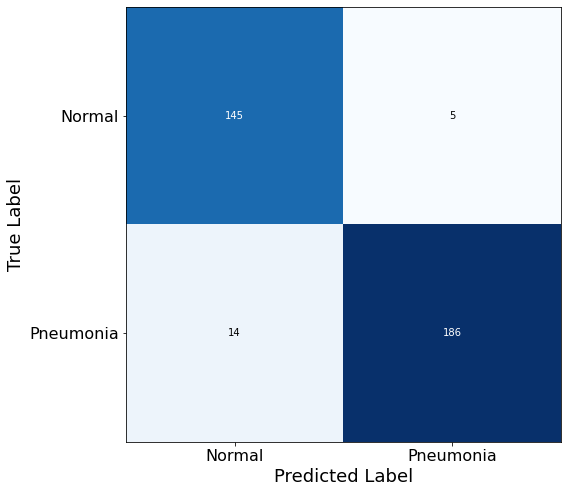

Accuracy of the model is 0.95
Recall of the model is 0.93
Precision of the model is 0.97
F1 Score of the model is 0.95


In [ ]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y_true = []
    y_pred = []

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        temp_pred = pred       
        y_pred+=(temp_pred.cpu().numpy().transpose().tolist())

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    y_pred = sum(y_pred,[])
    
    y_true = [int(dataloader.dataset.img_list[i][1]) for i in range(len(dataloader.dataset.img_list)) ]

    #plot confusion matrix
    cm  = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.xlabel('Predicted Label',fontsize=18)
    plt.ylabel('True Label',fontsize=18)
    plt.show()

    # Compute Performance Metrics
    tn, fp, fn, tp = cm.ravel()

    accuracy = (np.array(y_pred) == np.array(y_true)).sum() / len(y_pred)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    print("Accuracy of the model is {:.2f}".format(accuracy))
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))
    print("F1 Score of the model is {:.2f}".format(f1))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

**REFERENCES:**

1. Set up kaggle api in colab and download data:

https://www.kaggle.com/general/74235

https://stackoverflow.com/questions/60246795/how-to-set-up-kaggle-api-in-colab

2. Data source:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/notebooks?sortBy=relevance&group=everyone&search=Keras&page=1&pageSize=20&datasetId=17810

3. Most of the code is taken from this source:

https://blog.openmined.org/maintaining-privacy-in-medical-data-with-differential-privacy/

https://towardsdatascience.com/a-5-step-guide-on-incorporating-differential-privacy-into-your-deep-learning-models-7861c6c822c4

4. Confusion matrix Kaggle reference.

https://www.kaggle.com/teyang/pneumonia-detection-resnets-pytorch

Also tried using RESNET from same source. 

5. Source for vgg16, RESNET:

https://www.kaggle.com/dnik007/pneumonia-detection-using-pytorch

In [ ]:
#Previously dataset was downloaded via kaggle api
#import kaggle api
#!pip install -q kaggle 

#!mkdir ~/.kaggle
#!echo '{"username":"aradhyakhandeparker","key":"53f6a651956290b487bd268deb63072a"}' > ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

#unzip dataset
#!unzip /content/chest-xray-pneumonia.zip

In [ ]:
#class SimpleCNN(torch.nn.Module):
#    def __init__(self):
#        super(SimpleCNN, self).__init__() # b, 3, 32, 32
#        layer1 = torch.nn.Sequential()
#        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))

#        #b, 32, 32, 32
#        layer1.add_module('relu1', torch.nn.ReLU(True))
#        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
#        self.layer1 = layer1
#        layer4 = torch.nn.Sequential()
#        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
#        self.layer4 = layer4
#    def forward(self, x):
#        conv1 = self.layer1(x)
#        fc_input = conv1.view(conv1.size(0), -1)
#        fc_out = self.layer4(fc_input)
#
 #       return fc_out

In [ ]:
#def get_pretrained_model(model_name):
 #   """Retrieve a pre-trained model from torchvision
#
 #   Params
  #  -------
   #     model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    #Return
#    --------
 #       model (PyTorch model): cnn

  #  """

   # if model_name == 'vgg16':
    #    model = models.vgg16(pretrained=True)
#
 #       # Freeze early layers
  #      for param in model.parameters():
   #         param.requires_grad = False
    #    n_inputs = model.classifier[6].in_features
#
 #       # Add on classifier
  #      model.classifier[6] = nn.Sequential(
   #         nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    #        nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
#
 #   elif model_name == 'resnet50':
  #      model = models.resnet50(pretrained=True)
#
 #       for param in model.parameters():
  #          param.requires_grad = False
#
 #       n_inputs = model.fc.in_features
  #      model.fc = nn.Sequential(
   #         nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    #        nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))


   # return model